This notebook sets up the lensing simulator (`simulator`), noise model (`noise`) and subhalo parameter priors (`prior`). It also runs a few tests and benchmarks the simulator. It was developed on the `gpu_titanrtx_shared` partition on Lisa.

**Utilities.** These are just to check that the lensing model is working correctly.

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_fit_resids(config, n=100):
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    pred = torch.stack([config.ppd()['model_trace'].nodes['mu']['value'] for i in range(n)], 0).mean(0)
    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    
    err = np.ma.array((pred - OBS) / NOISE, mask=~MASK)
    vm = 2*np.sqrt((err**2).mean())

    im_kwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')
    cbar_kwargs = dict(fraction=0.046, pad=0.04)
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
    
    im = axes[0].imshow(OBS / NOISE, **im_kwargs)
    plt.colorbar(im, ax=axes[0], **cbar_kwargs)
    
    im = axes[1].imshow(pred / NOISE, **im_kwargs)
    plt.colorbar(im, ax=axes[1], **cbar_kwargs)
    
    im = axes[2].imshow(err, **im_kwargs, cmap='bwr', vmin=-vm, vmax=vm)
    plt.colorbar(im, ax=axes[2], **cbar_kwargs)
    
    plt.tight_layout()

**Set up simulator and noise model.**

In [5]:
import os
import torch
import pyro
import numpy as np
from operator import itemgetter
from ruamel.yaml import YAML
from clipppy.patches import torch_numpy
from clipppy import load_config

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

BASE_DIR = "scripts/conf/resources"
SYSTEM_NAME = 'hoags_object'
PARAMS = YAML().load(open(os.path.join(BASE_DIR, 'params.yaml')))[SYSTEM_NAME]

config = load_config(os.path.join(BASE_DIR, 'config-sh.yaml'), base_dir=BASE_DIR)
model, guide = config.umodel, config.guide

OBS = config.conditioning['image']
MASK = config.kwargs['defs']['mask']
NOISE = model.stochastic_specs['sigma_stat']

model.sources['src'] = config.kwargs['defs']['src']
model.sources['gp'] = config.kwargs['defs']['gp']
model.alphas['main'].stochastic_specs['slope'] = PARAMS['truth']['main/slope']

guide.setup()
guide = config.guide = torch.load(
    os.path.join(BASE_DIR, f'guide-{SYSTEM_NAME}-fixed-final.pt')
)

torch.set_default_tensor_type(torch.FloatTensor)  # HACK


def simulator(params):
    """
    Sample from the config's PPD, potentially with some parameters fixed, and put
    in a subhalo.
    
    Arguments
    - params: dict containing keys "x_sub", "y_sub", "log10_m_sub" whose values can
      be converted to floats.
    
    Returns
    - Numpy array. Could return a torch.Tensor if that would be more convenient.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    x_sub, y_sub, log10_m_sub = itemgetter("x_sub", "y_sub", "log10_m_sub")(
        {k: float(v) for k, v in params.items()}
    )

    def _guide():
        # Sample subhalo guide
        m_sub = pyro.sample(
            "main/sub/m_sub", dist.Delta(torch.tensor(10**log10_m_sub))
        )
        p_sub = pyro.sample(
            "main/sub/p_sub", dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)
        )
        # Sample from lens and source-plane GP guide
        config.guide.g()
        # Sample from image-plane GP guide
        config.guide.gp()

    result = {
        "mu": config.ppd(guide=_guide)["model_trace"].nodes["mu"]["value"].detach().numpy()
    }
    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    
    return result


def noise(obs, params=None, add_noise_outside_mask=True):
    """
    Noise model: adds Gaussian pixel noise to the image with the level specified
    when the config is loaded above.
    
    Arguments
    - add_noise_outside_mask: setting this to False will only add noise to the
      part of the image that is unmasked.
    """
    mu = obs["mu"]
    eps = np.random.randn(*mu.shape) * NOISE
    
    if not add_noise_outside_mask:
        eps[MASK] = 0.

    return {"mu": mu + eps}

**Check that everything is working.** Expected outputs:
- Three-panel plot where the first two panels look similar and the last contains values between approx. -3 to 3.
- ```Guide(
    (gp_alpha): DeltaSamplingGroup(1 sites, torch.Size([2]))
    (gp): DiagonalNormalSamplingGroup(1 sites, torch.Size([56454]))
    (src_alpha): DeltaSamplingGroup(1 sites, torch.Size([1]))
    (g): PartialMultivariateNormalSamplingGroup(8 sites, torch.Size([1607]))
)```

Guide(
  (gp_alpha): DeltaSamplingGroup(1 sites, torch.Size([2]))
  (gp): DiagonalNormalSamplingGroup(1 sites, torch.Size([56454]))
  (src_alpha): DeltaSamplingGroup(1 sites, torch.Size([1]))
  (g): PartialMultivariateNormalSamplingGroup(8 sites, torch.Size([1607]))
)


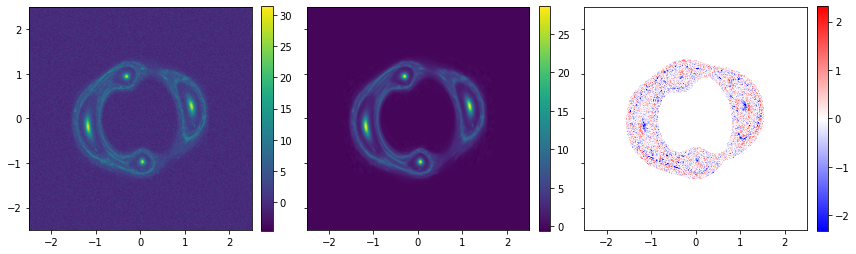

In [6]:
plot_fit_resids(config)
print(guide)

**Benchmark the simulator.**

In [5]:
%%timeit
simulator(
    {"x_sub": torch.rand(1), "y_sub": torch.rand(1), "log10_m_sub": torch.rand(1)}
)

43.4 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Set up subhalo parameter priors using yaml specifications.** In this case, this should be equivalent to:
```
prior = swyft.Prior({
    "x_sub": ['uniform', -2, 2],
    "y_sub": ['uniform', -2, 2],
    "log10_m_sub": ['uniform', 8.5, 10.5]
})
```

In [16]:
import swyft

prior_p_sub = config.umodel.alphas["main"].sub.pos_sampler.base_dist
prior_log10_m_sub = config.umodel.alphas["main"].sub.mass_sampler.base_dist
prior = swyft.Prior({
    "x_sub": [
        'uniform', prior_p_sub.low[0].cpu(), prior_p_sub.high[0].cpu()
    ],
    "y_sub": [
        'uniform', prior_p_sub.low[1].cpu(), prior_p_sub.high[1].cpu()
    ],
    "log10_m_sub": [
        'uniform', prior_log10_m_sub.low.cpu(), prior_log10_m_sub.high.cpu()
    ]
})

**Set up `swyft`.** Should take ~5 seconds to generate ~100 samples.

In [18]:
# TODO: maybe swyft could do this automatically?
param_names = list(prior.params())
obs_shapes = {k: v.shape for k, v in simulator(prior_sub.sample(1)).items()}

cache = swyft.MemoryCache(param_names, obs_shapes=obs_shapes)
cache.grow(prior, 100)
cache.simulate(simulator)

indices = cache.sample(prior, 100)
points = swyft.Points(indices, cache, noise)

Simulate:   2%|▏         | 2/98 [00:00<00:05, 18.04it/s]

Creating new cache.
  adding 98 new samples to simulator cache.


Simulate: 100%|██████████| 98/98 [00:04<00:00, 19.86it/s]


Next step: train posterior estimator!